In [1]:
from IPython.display import Audio
import librosa
import os
import random
import numpy as np

In [2]:
audio_endings = ('.mp3', '.wav', '.flac')

In [3]:
class AudioDataset:
    """
    Organize and load an audio dataset split into different directories
    """
    def __init__(self, ds_dir, sr, duration, shuffle=True, random_state=42):
        """
        """
        self.sr = sr
        self.duration = duration
        self.current_file_idx = 0
        self.files = []
        for r, d, f in os.walk(ds_dir):
            for file in f:
                if file.endswith(audio_endings):
                    self.files.append(os.path.join(r, file))
                    
        if shuffle:
            rand = random.Random(random_state)
            rand.shuffle(self.files)
            
    def num_samples(self):
        """
        Files/Samples in audio set
        """
        return len(self.files)
    
    def load(self, file_idxs, sr=None, duration=None, pbar=None):
        """
        Load the specified file indices as an np array of shape
        """
        if sr is None:
            sr = self.sr
        if duration is None:
            duration = self.duration
        ys = []
        if pbar is not None:
            pbar.reset(total=len(file_idxs))
        for file_idx in file_idxs:
            y, _ = librosa.load(self.files[file_idx], sr = sr,
                               mono=True, offset =0.0, duration=duration)
            y = librosa.util.fix_length(y, int(sr*duration), mode="wrap")
            ys.append(y)
            if pbar is not None:
                pbar.update(1)
        return np.array(ys)
    def load_next(self, batch_size, sr=None, duration=None, pbar=None):
        """
        Load the next batch_size files as an np array of shape (batch_size, sr*duration)
        """
        if self.cuurent_file_idx + batch_size>self.num_samples():
            self.current_file_idx = 0
        file_idxs = range(self.current_file_idx, self.current_file_idx + batch_size)
        
        self.current_file_idx += batch_size
        return self.load(file_idxs, sr= sr, duration=duration, pbar=pbar)
    def reset_next(self):
        """
        Reset file index for the load_next function
        """
        self.current_file_idx = 0

In [8]:
sr = 8000
duration = 5.0
voice_ds = AudioDataset("../input/libri-dataset-train-100/LibriSpeech/train-clean-100/103/1240/",
                       sr=sr, duration=duration)

In [9]:
num_sampples = voice_ds.num_samples()

In [10]:
num_sampples

58

In [11]:
voice = voice_ds.load(range(num_sampples), pbar=tqdm())

0it [00:00, ?it/s]

In [16]:
voice.shape

(58, 40000)

In [39]:
import matplotlib.pyplot as plt
import torch
import torchaudio
import warnings
warnings.filterwarnings("ignore")
import IPython.display as ipd
X = torch.from_numpy(voice)

In [40]:
n_fft = 400
y = X[:1]
print(y.shape)
spec = y.stft(n_fft).permute(0,-1,-3,-2)
print(spec.shape)
y_p = torch.istft(spec.permute(0,-2,-1,-3),n_fft)
y_p.shape

torch.Size([1, 40000])
torch.Size([1, 2, 201, 401])


torch.Size([1, 40000])

In [41]:
ipd.Audio(y[0], rate=8000)

In [42]:
y.stft(300, ).shape

torch.Size([1, 151, 534, 2])

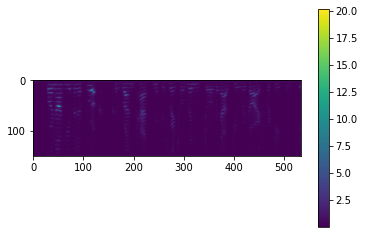

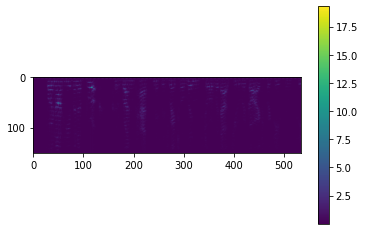

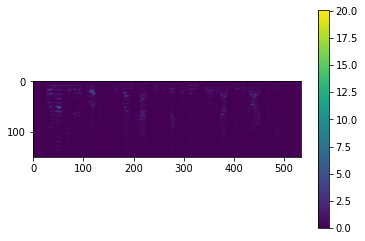

In [43]:
plt.imshow(y.stft(300, normalized=False).norm(dim=-1, ).numpy()[0])
plt.colorbar()
plt.show()

plt.imshow(y.stft(300, normalized=False)[..., 0].abs().numpy()[0])
plt.colorbar()
plt.show()

plt.imshow(y.stft(300, normalized=False)[..., 1].abs().numpy()[0])
plt.colorbar()
plt.show()

In [56]:
class AudioSSNNIO():
    """
    Class to control Neural Network Input/Output
    """
    def __init__(self, sr, duration):
        """
        Initialize with sr, duration, and the number of sources.
        """
        self.sr = sr
        self.duration = duration
        
    def audio_to_nn_input(self, X_batch):
        """
        Transform the given mixed signal for the neural network to input.
        X_batch will have shape (batch_size, len(y)) where len(y) = sr*duration
        """
        raise NotImplementedError
    def audio_to_nn_output(self, Y_batch):
        """
        Transform the given source separated signals for the neural network to output.
        Y_batch will have shape (batch_size, num_sources=2, len(y)) where len(y) = sr*duration.
        """
        raise NotImplementedError
        
    def nn_input_to_audio(self, X_batch):
        """
        Transform the input of the neural network back into usable audio.
        X_batch will have shape (batch_size, nn_num_input_channels(), h, w) where h, w are 
        determined by the size of the input spectrum in audio_to_nn_input(...).
        """
        raise NotImplementedError

    def nn_output_to_audio(self, Y_batch):
        """
        Transform the output of the neural network back into usable audio.
        Y_batch will have shape (batch_size, nn_num_output_channels(), h, w) where h, w are 
        determined by the size of the input spectrum in audio_to_nn_output(...).
        """
        raise NotImplementedError
        
    def show_play_nn_input(self, X_batch, ts=["raw", "audio"], sample_idx=0):
        """
        Convenience wrapper to fast show and play network input.
        """
        y = self.nn_input_to_audio(X_batch)[sample_idx]
        return self.show_play_audio(y, ts)
    def show_play_nn_output(self, Y_batch, ts=["raw", "audio"], sample_idx=0):
        """
        Convenience wrapper to fast show and play network output.
        """
        y = self.nn_output_to_audio(Y_batch)[sample_idx]
        return self.show_play_audio(y, ts)
    
    # for jupyter notebook only
    def show_play_audio(self, y, ts=["raw", "audio"]):
        """
        Show the signal y in a jupyter notebook. 
        ts determines different ways you want to show the signal. 
        ts can have:
        -"raw"
        -"audio"
        other options can be added on by different implementations.
        """
        
        if "raw" in ts:
            plt.plot(np.linspace(0, self.duration, len(y)), y)
            plt.show()
        if "audio" in ts:
            display(Audio(y, rate=self.sr))

In [70]:
class BaseNNIO(AudioSSNNIO):
    def __init__(self, sr, duration, n_fft=300, normalized=False, magphase_representation=False):
        super().__init__(sr, duration)
        self.n_fft = n_fft
        self.normalized = normalized
        self.magphase_representation = magphase_representation
        
    def audio_to_nn_input(self, X_batch):
        # X_batch is (batch_size, len(y))
        
        X_batch = X_batch.stft(n_fft=self.n_fft, normalized=self.normalized) #stft
        if self.magphase_representation: # magphase
            X_batch_mag, X_batch_phase = torchaudio.functional.magphase(X_batch)
            X_batch = torch.stack((X_batch_mag, X_batch_phase), dim=-1)
        X_batch =  X_batch.permute(0, -1, -3, -2) # shape
        return X_batch
    
    def audio_to_nn_output(self, Y_batch):
        # Y_batch is (batch_size, num_sources=2, len(y))
        Y_batch = Y_batch[:, 0, :].stft(n_fft=self.n_fft, normalized=self.normalized) #stft
        if self.magphase_representation: #magphase
            Y_batch_mag, Y_batch_phase = torchaudio.functional.magphase(Y_batch)
            Y_batch = torch.stack((Y_batch_mag, Y_batch_phase), dim=-1)
        Y_batch = Y_batch.permute(0, -1, -3, -2) # shape
        return Y_batch
    
    def nn_input_to_audio(self, X_batch):
        X_batch = X_batch.permute(0, -2, -1, -3) # shape
        if self.magphase_representation: # magphase
            X_batch_real = X_batch[..., 0] * torch.cos(X_batch[..., 1])
            X_batch_imag = X_batch[..., 0] * torch.sin(X_batch[..., 1])
            X_batch = torch.stack((X_batch_real, X_batch_imag), dim=-1)
        
        X_batch = torch.istft(X_batch, n_fft=self.n_fft, #istft
                                              normalized=self.normalized, length=int(X.shape[1]))
        
        return X_batch
    def nn_output_to_audio(self, Y_batch, X_batch, transform_X_batch=True):
        Y_batch = Y_batch.permute(0, -2, -1, -3) # shape
        if self.magphase_representation: # magphase
            Y_batch_real = Y_batch[..., 0] * torch.cos(Y_batch[..., 1])
            Y_batch_imag = Y_batch[..., 0] * torch.sin(Y_batch[..., 1])
            Y_batch = torch.stack((Y_batch_real, Y_batch_imag), dim=-1)
        
        Y_batch = torch.istft(Y_batch, n_fft=self.n_fft, #istft
                                              normalized=self.normalized, length=int(X.shape[1]))
        
        if transform_X_batch:
            X_batch = self.nn_input_to_audio(X_batch)
        
        Y_batch_noise = X_batch - Y_batch
        
        Y_batch = torch.stack((Y_batch, Y_batch_noise), dim=-2)
        return Y_batch
        
        
    # for jupyter notebook only
    def show_play_audio(self, y, ts=["raw", "audio"]):
        spectrogram = y.stft(n_fft=self.n_fft, normalized=self.normalized)
        spec_mag, spec_phase = torchaudio.functional.magphase(spectrogram)
        
        if "mag" in ts:
            plt.figure(figsize=(10,4))
            plt.imshow(spec_mag.numpy())
            plt.colorbar(format="%2.2f")
            plt.title("Magnitude of STFT")
            plt.tight_layout()
            plt.show()
        if "detail" in ts:
            fig, axs = plt.subplots(2,2, figsize=(10,4))
            axs[0, 0].set_title("Magnitude")
            axs[0, 1].set_title("Phase")
            axs[1, 0].set_title("Real Part")
            axs[1, 1].set_title("Imag Part")
            
            axs[0, 0].imshow(spec_mag.numpy())
            axs[0, 1].imshow(spec_phase.numpy())
            axs[1, 0].imshow(spectrogram[..., 0].numpy())
            axs[1, 1].imshow(spectrogram[..., 1].numpy())
            plt.show()
        super().show_play_audio(y, ts)

In [71]:
base = BaseNNIO(8000, 2.0, magphase_representation=True)

In [72]:
Y = torch.stack((X[:10], X[:10]), dim=-2)
Y.shape

torch.Size([10, 2, 40000])

In [73]:
X[:10].shape

torch.Size([10, 40000])

In [74]:
(base.nn_input_to_audio(base.audio_to_nn_input(X[:10]))-X[:10]).abs().sum()

tensor(0.0006)

In [75]:
(base.nn_output_to_audio(base.audio_to_nn_output(Y), 2*X[:10], transform_X_batch=False)-Y).abs().sum()

tensor(0.0013)

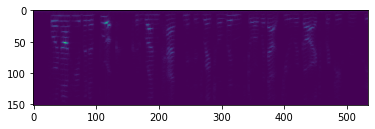

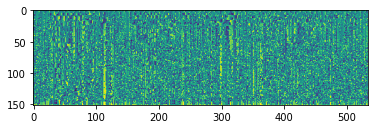

In [76]:
plt.imshow(base.audio_to_nn_input(X[:1])[0, 0])
plt.show()
plt.imshow(base.audio_to_nn_input(X[:1])[0, 1])
plt.show()

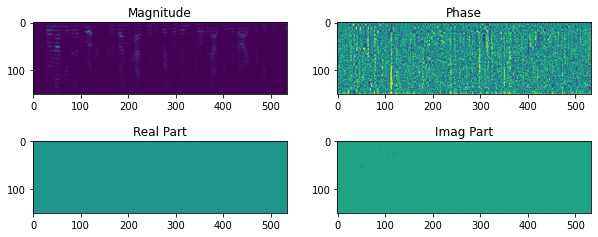

In [77]:
base.show_play_audio(X[0], ts=['detail'])